# Modeling NYC Apartment Rental Pricing on Craigslist

This notebook explores NYC Apartment Rental listing data I collected from Craigslist. The goal of the notebook is to try to use Linear Regression to predict apartment rental prices based on listings scraped from craigslist.

Collected listings are from the NYC area (using [newyork.craigslist.com](https://newyork.craigslist.com/search/apa)) with listings from the date range: `2019-12-24` to `2020-01-23`.



In [1]:
import re
import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [ ]:
db = sqlite3.connect('data/craigslist_apts.db')
c = db.cursor()

In [156]:
df2 = pd.read_sql(
    "SELECT * FROM cl_apts;", 
    db
)
df2.head()

,post_id,link,price,description,n_images,post_time,title,placename,lat,lon,location,housing,attrs,sqft,beds,dogs_ok,cats_ok
0,7061095886,https://newyork.craigslist.org/mnh/apa/d/new-y...,3950.0,enormous apartment. ideal for roommates and sh...,0,2020-01-22 15:58,huge flex 4 bedrooms awesome deal 52 st 9ave,manhattan,40.754925,-73.96476,Midtown West,4br,4br / 1ba broker fee details: brokers fee nego...,NaN,4.0,1.0,1.0
1,7061095044,https://newyork.craigslist.org/que/apa/d/jamai...,2250.0,welcome to wexford hall apartments in beautifu...,14,2020-01-22 15:57,jamaica estates renovated 2br 1bth in luxury b...,jamaica estates,40.711900,-73.79440,Jamaica Estates,2br 1000ft2,2br / 1ba 1000ft2 application fee details: $20...,1000.0,2.0,0.0,0.0
2,7061094612,https://newyork.craigslist.org/que/apa/d/jamai...,1649.0,welcome to wilshire hall apartments beautiful ...,18,2020-01-22 15:56,jamaica estates reno alcove studio in luxury b...,jamaica estates,40.711900,-73.79440,Jamaica Estates,550ft2,0br / 1ba 550ft2 application fee details: $20....,550.0,0.0,0.0,0.0
3,7061094200,https://newyork.craigslist.org/que/apa/d/jamai...,2475.0,open house 516 660 0246 welcome to edgerton ha...,20,2020-01-22 15:56,open house. jamaica estates reno 2 2bth balcon...,jamaica estates,40.711900,-73.79440,Jamaica Estates,2br 1000ft2,2br / 2ba 1000ft2 application fee details: $20...,1000.0,2.0,0.0,0.0
4,7061093913,https://newyork.craigslist.org/que/apa/d/jamai...,1599.0,open house monday 01 20 2020 11 12 30pm 516 66...,13,2020-01-22 15:55,open house. briarwood luxury renovated studios...,briarwood,40.702900,-73.81110,BRIARWOOD,400ft2,0br / 1ba 400ft2 application fee details: $19....,400.0,0.0,0.0,0.0


In [157]:
df2.describe()

,price,n_images,lat,lon,sqft,beds,dogs_ok,cats_ok
count,9601.000000,9709.000000,9622.000000,9622.000000,2484.000000,9224.000000,9621.000000,9621.000000
mean,2758.624727,8.539396,40.719123,-73.905175,979.452496,1.848005,0.556387,0.632575
std,1184.512757,5.306744,1.494552,1.390644,2096.345355,3.304965,0.496836,0.482129
min,1.000000,0.000000,-84.756429,-98.142350,1.000000,0.000000,0.000000,0.000000
25%,1880.000000,5.000000,40.689255,-73.987347,695.000000,1.000000,0.000000,0.000000
50%,2520.000000,8.000000,40.719786,-73.949908,850.000000,2.000000,1.000000,1.000000
75%,3450.000000,11.000000,40.768471,-73.902845,1067.000000,2.000000,1.000000,1.000000
max,25500.000000,24.000000,43.044045,0.000000,99999.000000,276.000000,1.000000,1.000000


In [2]:
df = pd.read_sql(
    "SELECT * FROM cl_apts;", 
    db
)
df.post_time = df.post_time.apply(pd.to_datetime)

In [3]:
df.head()

,post_id,link,price,description,n_images,post_time,title,placename,lat,lon,location,housing,attrs,sqft,beds,dogs_ok,cats_ok
0,7061095886,https://newyork.craigslist.org/mnh/apa/d/new-y...,3950.0,enormous apartment. ideal for roommates and sh...,0,2020-01-22 15:58:00,huge flex 4 bedrooms awesome deal 52 st 9ave,manhattan,40.754925,-73.96476,Midtown West,4br,4br / 1ba broker fee details: brokers fee nego...,NaN,4.0,1.0,1.0
1,7061095044,https://newyork.craigslist.org/que/apa/d/jamai...,2250.0,welcome to wexford hall apartments in beautifu...,14,2020-01-22 15:57:00,jamaica estates renovated 2br 1bth in luxury b...,jamaica estates,40.711900,-73.79440,Jamaica Estates,2br 1000ft2,2br / 1ba 1000ft2 application fee details: $20...,1000.0,2.0,0.0,0.0
2,7061094612,https://newyork.craigslist.org/que/apa/d/jamai...,1649.0,welcome to wilshire hall apartments beautiful ...,18,2020-01-22 15:56:00,jamaica estates reno alcove studio in luxury b...,jamaica estates,40.711900,-73.79440,Jamaica Estates,550ft2,0br / 1ba 550ft2 application fee details: $20....,550.0,0.0,0.0,0.0
3,7061094200,https://newyork.craigslist.org/que/apa/d/jamai...,2475.0,open house 516 660 0246 welcome to edgerton ha...,20,2020-01-22 15:56:00,open house. jamaica estates reno 2 2bth balcon...,jamaica estates,40.711900,-73.79440,Jamaica Estates,2br 1000ft2,2br / 2ba 1000ft2 application fee details: $20...,1000.0,2.0,0.0,0.0
4,7061093913,https://newyork.craigslist.org/que/apa/d/jamai...,1599.0,open house monday 01 20 2020 11 12 30pm 516 66...,13,2020-01-22 15:55:00,open house. briarwood luxury renovated studios...,briarwood,40.702900,-73.81110,BRIARWOOD,400ft2,0br / 1ba 400ft2 application fee details: $19....,400.0,0.0,0.0,0.0


In [4]:
df.describe()

,price,n_images,lat,lon,sqft,beds,dogs_ok,cats_ok
count,9601.000000,9709.000000,9622.000000,9622.000000,2484.000000,9224.000000,9621.000000,9621.000000
mean,2758.624727,8.539396,40.719123,-73.905175,979.452496,1.848005,0.556387,0.632575
std,1184.512757,5.306744,1.494552,1.390644,2096.345355,3.304965,0.496836,0.482129
min,1.000000,0.000000,-84.756429,-98.142350,1.000000,0.000000,0.000000,0.000000
25%,1880.000000,5.000000,40.689255,-73.987347,695.000000,1.000000,0.000000,0.000000
50%,2520.000000,8.000000,40.719786,-73.949908,850.000000,2.000000,1.000000,1.000000
75%,3450.000000,11.000000,40.768471,-73.902845,1067.000000,2.000000,1.000000,1.000000
max,25500.000000,24.000000,43.044045,0.000000,99999.000000,276.000000,1.000000,1.000000


***

Setting a price cutoff to remove rental outliers...

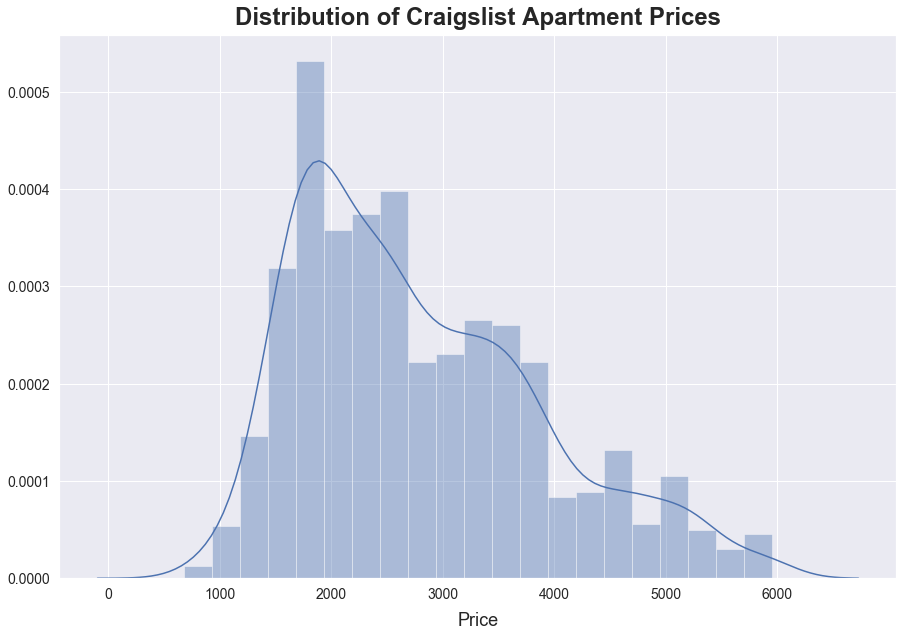

In [128]:
price_cutoff = 6000

plt.figure(figsize=(15,10))
sns.distplot(
    df.price[
        (df.price < price_cutoff) &
        (df.price > 100)
    ]
)
plt.title(
    f"Distribution of Craigslist Apartment Prices",
    fontsize=24,
    fontweight='bold',
    pad=10
)
plt.xlabel(
    'Price',
    fontsize=18,
    labelpad=10
)
plt.xticks(
    [i*1000 for i in range(7)],
    fontsize=14
)
plt.yticks(
    fontsize=14
)
# plt.show()
plt.savefig("./images/apartment_price_distribution.png")

In [6]:
# Drop values below that cutoff
df = df[df.price < price_cutoff]

Also setting a $ft^2$ cutoff, to remove outliers...

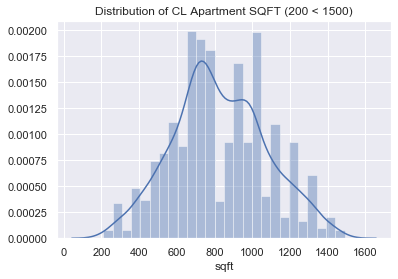

In [7]:
sqft_max = 1500 #1000
sqft_min = 200 #600

sns.distplot(
    df.sqft[
        (df.sqft < sqft_max) &
        (df.sqft > sqft_min)
    ]
)
plt.title(f"Distribution of CL Apartment SQFT ({sqft_min} < {sqft_max})")
plt.show()

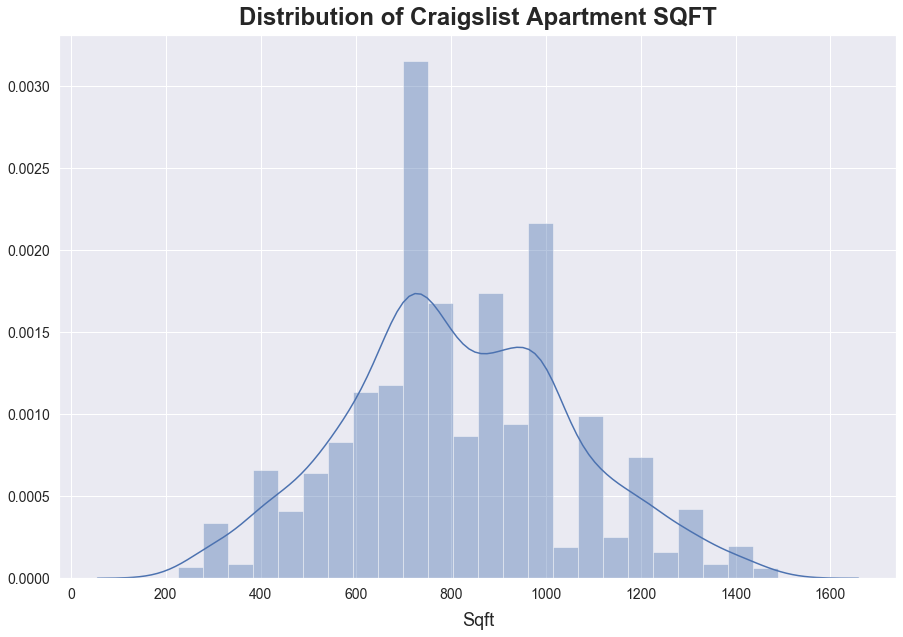

In [149]:
plt.figure(figsize=(15,10))
sns.distplot(
    df.sqft[
        (df.sqft < sqft_max) &
        (df.sqft > sqft_min)
    ]
)
plt.title(
    "Distribution of Craigslist Apartment SQFT",
    fontsize=24,
    fontweight='bold',
    pad=10
)
plt.xlabel(
    'Sqft',
    fontsize=18,
    labelpad=10
)
plt.xticks(
#     [i*1000 for i in range(7)],
    fontsize=14
)
plt.yticks(
    fontsize=14
)
# plt.show()
plt.savefig("./images/apartment_sqft_distribution.png")

In [136]:
df.describe()

,price,n_images,lat,lon,sqft,beds,dogs_ok,cats_ok
count,1902.000000,1902.000000,1902.000000,1902.000000,1902.000000,1902.000000,1901.000000,1901.000000
mean,2712.292324,8.760252,40.739636,-73.942467,816.773922,1.528917,0.475013,0.558653
std,1174.862755,5.052105,0.088389,0.068455,240.508186,0.979514,0.499507,0.496679
min,1.000000,0.000000,40.534748,-74.147200,225.000000,0.000000,0.000000,0.000000
25%,1850.000000,5.000000,40.690700,-73.985800,660.000000,1.000000,0.000000,0.000000
50%,2500.000000,8.000000,40.731300,-73.951100,800.000000,1.000000,0.000000,1.000000
75%,3495.000000,12.000000,40.767645,-73.902884,1000.000000,2.000000,1.000000,1.000000
max,5950.000000,24.000000,40.992700,-73.711414,1490.000000,6.000000,1.000000,1.000000


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1902 entries, 7043852389 to 7061671040
Data columns (total 18 columns):
link            1902 non-null object
price           1902 non-null float64
description     1901 non-null object
n_images        1902 non-null int64
post_time       1902 non-null datetime64[ns]
title           1902 non-null object
placename       1902 non-null object
lat             1902 non-null float64
lon             1902 non-null float64
location        1794 non-null object
housing         1902 non-null object
attrs           1901 non-null object
sqft            1902 non-null float64
beds            1902 non-null float64
dogs_ok         1901 non-null float64
cats_ok         1901 non-null float64
neighborhood    1902 non-null object
borough         1902 non-null object
dtypes: datetime64[ns](1), float64(7), int64(1), object(9)
memory usage: 362.3+ KB


In [8]:
# Drop values below that cutoff
df = df[
        (df.sqft < sqft_max) &
        (df.sqft > sqft_min)
    ]

In [9]:
df.beds.value_counts(dropna=False).sort_index()

0.0     261
1.0     866
2.0     713
3.0     313
4.0      37
5.0       3
6.0       1
10.0      1
16.0      2
20.0      1
NaN      45
Name: beds, dtype: int64

In [10]:
df.loc[(df.beds > 9),'beds'] = 0

In [11]:
df.beds = df.beds.fillna(0)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2243 entries, 1 to 9706
Data columns (total 17 columns):
post_id        2243 non-null object
link           2243 non-null object
price          2243 non-null float64
description    2242 non-null object
n_images       2243 non-null int64
post_time      2243 non-null datetime64[ns]
title          2243 non-null object
placename      2243 non-null object
lat            2243 non-null float64
lon            2243 non-null float64
location       2065 non-null object
housing        2243 non-null object
attrs          2242 non-null object
sqft           2243 non-null float64
beds           2243 non-null float64
dogs_ok        2242 non-null float64
cats_ok        2242 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1), object(8)
memory usage: 315.4+ KB


Setting cutoffs for latitude and longitude...

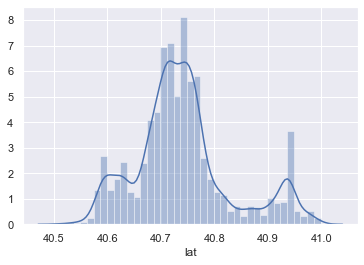

In [13]:
lat_max = 41
lat_min = 40.5

sns.distplot(
    df.lat[
        (df.lat < lat_max) &
        (df.lat > lat_min)
    ]
)

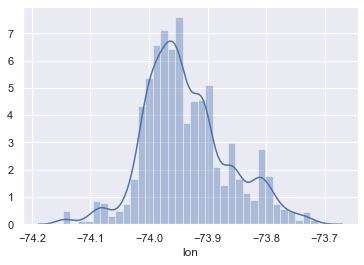

In [14]:
lon_max = -73.7
lon_min = -74.15

sns.distplot(
    df.lon[
        (df.lon < lon_max) &
        (df.lon > lon_min)
    ]
)

In [15]:
df = df[
    (df.lon < lon_max) &
    (df.lon > lon_min) & 
    (df.lat < lat_max) &
    (df.lat > lat_min)
]

In [16]:
neighborhood_df = df[['post_id','lat','lon']]
neighborhood_df.to_pickle("./pickles/neighborhood_df.pkl")

___Go to the Other Notebook!___ in order to get data on neighborhood names based on _latitide_/_longitude_ and then pick up again __here__...

In [17]:
# Load the pickle created by the other notebook
neighborhood_df = pd.read_pickle("./pickles/neighborhood_df.pkl").set_index('post_id')
neighborhood_df.head()

,lat,lon,neighborhood,borough
post_id,,,,
7043852389,40.706367,-74.015660,Battery Park City-Lower Manhattan,Manhattan
7043879172,40.751654,-73.999723,Hudson Yards-Chelsea-Flatiron-Union Square,Manhattan
7043882068,40.726958,-74.003445,SoHo-TriBeCa-Civic Center-Little Italy,Manhattan
7043897638,40.757100,-73.965700,Turtle Bay-East Midtown,Manhattan
7043924975,40.681221,-73.980463,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,Brooklyn


In [18]:
neighborhood_df.borough.value_counts()

Manhattan        568
Brooklyn         545
Queens           424
Other            228
Bronx             73
Staten Island     56
Name: borough, dtype: int64

In [19]:
neighborhood_df.neighborhood.value_counts().head(15)

Other                                         228
Battery Park City-Lower Manhattan              84
Hunters Point-Sunnyside-West Maspeth           67
Astoria                                        58
SoHo-TriBeCa-Civic Center-Little Italy         44
Turtle Bay-East Midtown                        42
Bay Ridge                                      41
Clinton                                        39
Hudson Yards-Chelsea-Flatiron-Union Square     39
Bushwick South                                 39
Crown Heights North                            39
Bedford                                        38
Murray Hill-Kips Bay                           38
North Side-South Side                          31
Upper West Side                                30
Name: neighborhood, dtype: int64

In [20]:
df.set_index('post_id',inplace=True,drop=True)
df.head()

,link,price,description,n_images,post_time,title,placename,lat,lon,location,housing,attrs,sqft,beds,dogs_ok,cats_ok
post_id,,,,,,,,,,,,,,,,
7061095044,https://newyork.craigslist.org/que/apa/d/jamai...,2250.0,welcome to wexford hall apartments in beautifu...,14,2020-01-22 15:57:00,jamaica estates renovated 2br 1bth in luxury b...,jamaica estates,40.711900,-73.794400,Jamaica Estates,2br 1000ft2,2br / 1ba 1000ft2 application fee details: $20...,1000.0,2.0,0.0,0.0
7061094612,https://newyork.craigslist.org/que/apa/d/jamai...,1649.0,welcome to wilshire hall apartments beautiful ...,18,2020-01-22 15:56:00,jamaica estates reno alcove studio in luxury b...,jamaica estates,40.711900,-73.794400,Jamaica Estates,550ft2,0br / 1ba 550ft2 application fee details: $20....,550.0,0.0,0.0,0.0
7061094200,https://newyork.craigslist.org/que/apa/d/jamai...,2475.0,open house 516 660 0246 welcome to edgerton ha...,20,2020-01-22 15:56:00,open house. jamaica estates reno 2 2bth balcon...,jamaica estates,40.711900,-73.794400,Jamaica Estates,2br 1000ft2,2br / 2ba 1000ft2 application fee details: $20...,1000.0,2.0,0.0,0.0
7061093913,https://newyork.craigslist.org/que/apa/d/jamai...,1599.0,open house monday 01 20 2020 11 12 30pm 516 66...,13,2020-01-22 15:55:00,open house. briarwood luxury renovated studios...,briarwood,40.702900,-73.811100,BRIARWOOD,400ft2,0br / 1ba 400ft2 application fee details: $19....,400.0,0.0,0.0,0.0
7061093626,https://newyork.craigslist.org/que/apa/d/sunny...,2199.0,welcome to beautiful park briar in forest hill...,12,2020-01-22 15:55:00,forest hills renovated 1br 1bth in luxury buil...,forest hills,40.743201,-73.920591,Forest Hills,1br 750ft2,1br / 1ba 750ft2 application fee details: $20....,750.0,1.0,0.0,0.0


In [21]:
df = df.join(neighborhood_df.drop(columns=['lat','lon']))

In [22]:
df.head()

,link,price,description,n_images,post_time,title,placename,lat,lon,location,housing,attrs,sqft,beds,dogs_ok,cats_ok,neighborhood,borough
post_id,,,,,,,,,,,,,,,,,,
7043852389,https://newyork.craigslist.org/mnh/apa/d/new-y...,3500.0,just listed. no fee one bedroom private terrac...,10,2019-12-24 09:10:00,just listed. no fee one bedroom private terrace,new york,40.706367,-74.015660,Financial District,1br 700ft2,1br / 1ba 700ft2 listed by: tomer meir spire g...,700.0,1.0,0.0,0.0,Battery Park City-Lower Manhattan,Manhattan
7043879172,https://newyork.craigslist.org/mnh/apa/d/new-y...,4495.0,broker fee will apply available 2 1. actual ph...,8,2019-12-24 10:12:00,amazing sun lit nomad lofty 1 bed stunner full...,new york,40.751654,-73.999723,Flatiron,1br 700ft2,1br / 1ba 700ft2 available feb 1 broker fee de...,700.0,1.0,0.0,0.0,Hudson Yards-Chelsea-Flatiron-Union Square,Manhattan
7043882068,https://newyork.craigslist.org/mnh/apa/d/new-y...,4495.0,broker fee will apply available 2 1. actual ph...,7,2019-12-24 10:19:00,amazing sun lit soho 1 bed stunner private bal...,new york,40.726958,-74.003445,SoHo,1br 700ft2,1br / 1ba 700ft2 available feb 1 broker fee de...,700.0,1.0,0.0,0.0,SoHo-TriBeCa-Civic Center-Little Italy,Manhattan
7043897638,https://newyork.craigslist.org/mnh/apa/d/new-y...,3795.0,massive classic junior 4 fully renovated great...,6,2019-12-24 10:53:00,nofee 1000sqft 1br doorman gym elevator laundr...,new york,40.757100,-73.965700,Midtown East,1br 1000ft2,1br / 1ba 1000ft2 available feb 1 apartment la...,1000.0,1.0,1.0,1.0,Turtle Bay-East Midtown,Manhattan
7043924975,https://newyork.craigslist.org/brk/apa/d/brook...,3597.0,we bought an apartment so we re looking to tur...,8,2019-12-24 11:45:00,beautiful 2br 2ba with balcony w d ac 3 597,brooklyn,40.681221,-73.980463,Brooklyn,2br 750ft2,2br / 2ba 750ft2 available jan 13 open house d...,750.0,2.0,0.0,0.0,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,Brooklyn


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1902 entries, 7043852389 to 7061671040
Data columns (total 18 columns):
link            1902 non-null object
price           1902 non-null float64
description     1901 non-null object
n_images        1902 non-null int64
post_time       1902 non-null datetime64[ns]
title           1902 non-null object
placename       1902 non-null object
lat             1902 non-null float64
lon             1902 non-null float64
location        1794 non-null object
housing         1902 non-null object
attrs           1901 non-null object
sqft            1902 non-null float64
beds            1902 non-null float64
dogs_ok         1901 non-null float64
cats_ok         1901 non-null float64
neighborhood    1902 non-null object
borough         1902 non-null object
dtypes: datetime64[ns](1), float64(7), int64(1), object(9)
memory usage: 282.3+ KB


In [24]:
df.neighborhood.unique().shape, df.borough.unique().shape

((153,), (6,))

In [25]:
subset_df = df[[
    'price',
    'n_images',
    'lat',
    'lon',
    'sqft',
    'beds',
    'dogs_ok',
    'cats_ok',
    'neighborhood',
    'borough'
]].dropna()
subset_df.head()

,price,n_images,lat,lon,sqft,beds,dogs_ok,cats_ok,neighborhood,borough
post_id,,,,,,,,,,
7043852389,3500.0,10,40.706367,-74.015660,700.0,1.0,0.0,0.0,Battery Park City-Lower Manhattan,Manhattan
7043879172,4495.0,8,40.751654,-73.999723,700.0,1.0,0.0,0.0,Hudson Yards-Chelsea-Flatiron-Union Square,Manhattan
7043882068,4495.0,7,40.726958,-74.003445,700.0,1.0,0.0,0.0,SoHo-TriBeCa-Civic Center-Little Italy,Manhattan
7043897638,3795.0,6,40.757100,-73.965700,1000.0,1.0,1.0,1.0,Turtle Bay-East Midtown,Manhattan
7043924975,3597.0,8,40.681221,-73.980463,750.0,2.0,0.0,0.0,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,Brooklyn


In [154]:
subset_df.describe().transpose()[['mean','std']]

,mean,std
price,2713.008943,1174.756016
n_images,8.764861,5.049434
lat,40.739633,0.088412
lon,-73.942476,0.068472
sqft,816.845871,240.550995
beds,1.529195,0.979696
dogs_ok,0.475013,0.499507
cats_ok,0.558653,0.496679


In [26]:
dummied_df = pd.get_dummies(subset_df,columns=['borough']).drop(columns='borough_Other')
dummied_df.head()

,price,n_images,lat,lon,sqft,beds,dogs_ok,cats_ok,neighborhood,borough_Bronx,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island
post_id,,,,,,,,,,,,,,
7043852389,3500.0,10,40.706367,-74.015660,700.0,1.0,0.0,0.0,Battery Park City-Lower Manhattan,0,0,1,0,0
7043879172,4495.0,8,40.751654,-73.999723,700.0,1.0,0.0,0.0,Hudson Yards-Chelsea-Flatiron-Union Square,0,0,1,0,0
7043882068,4495.0,7,40.726958,-74.003445,700.0,1.0,0.0,0.0,SoHo-TriBeCa-Civic Center-Little Italy,0,0,1,0,0
7043897638,3795.0,6,40.757100,-73.965700,1000.0,1.0,1.0,1.0,Turtle Bay-East Midtown,0,0,1,0,0
7043924975,3597.0,8,40.681221,-73.980463,750.0,2.0,0.0,0.0,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,0,1,0,0,0


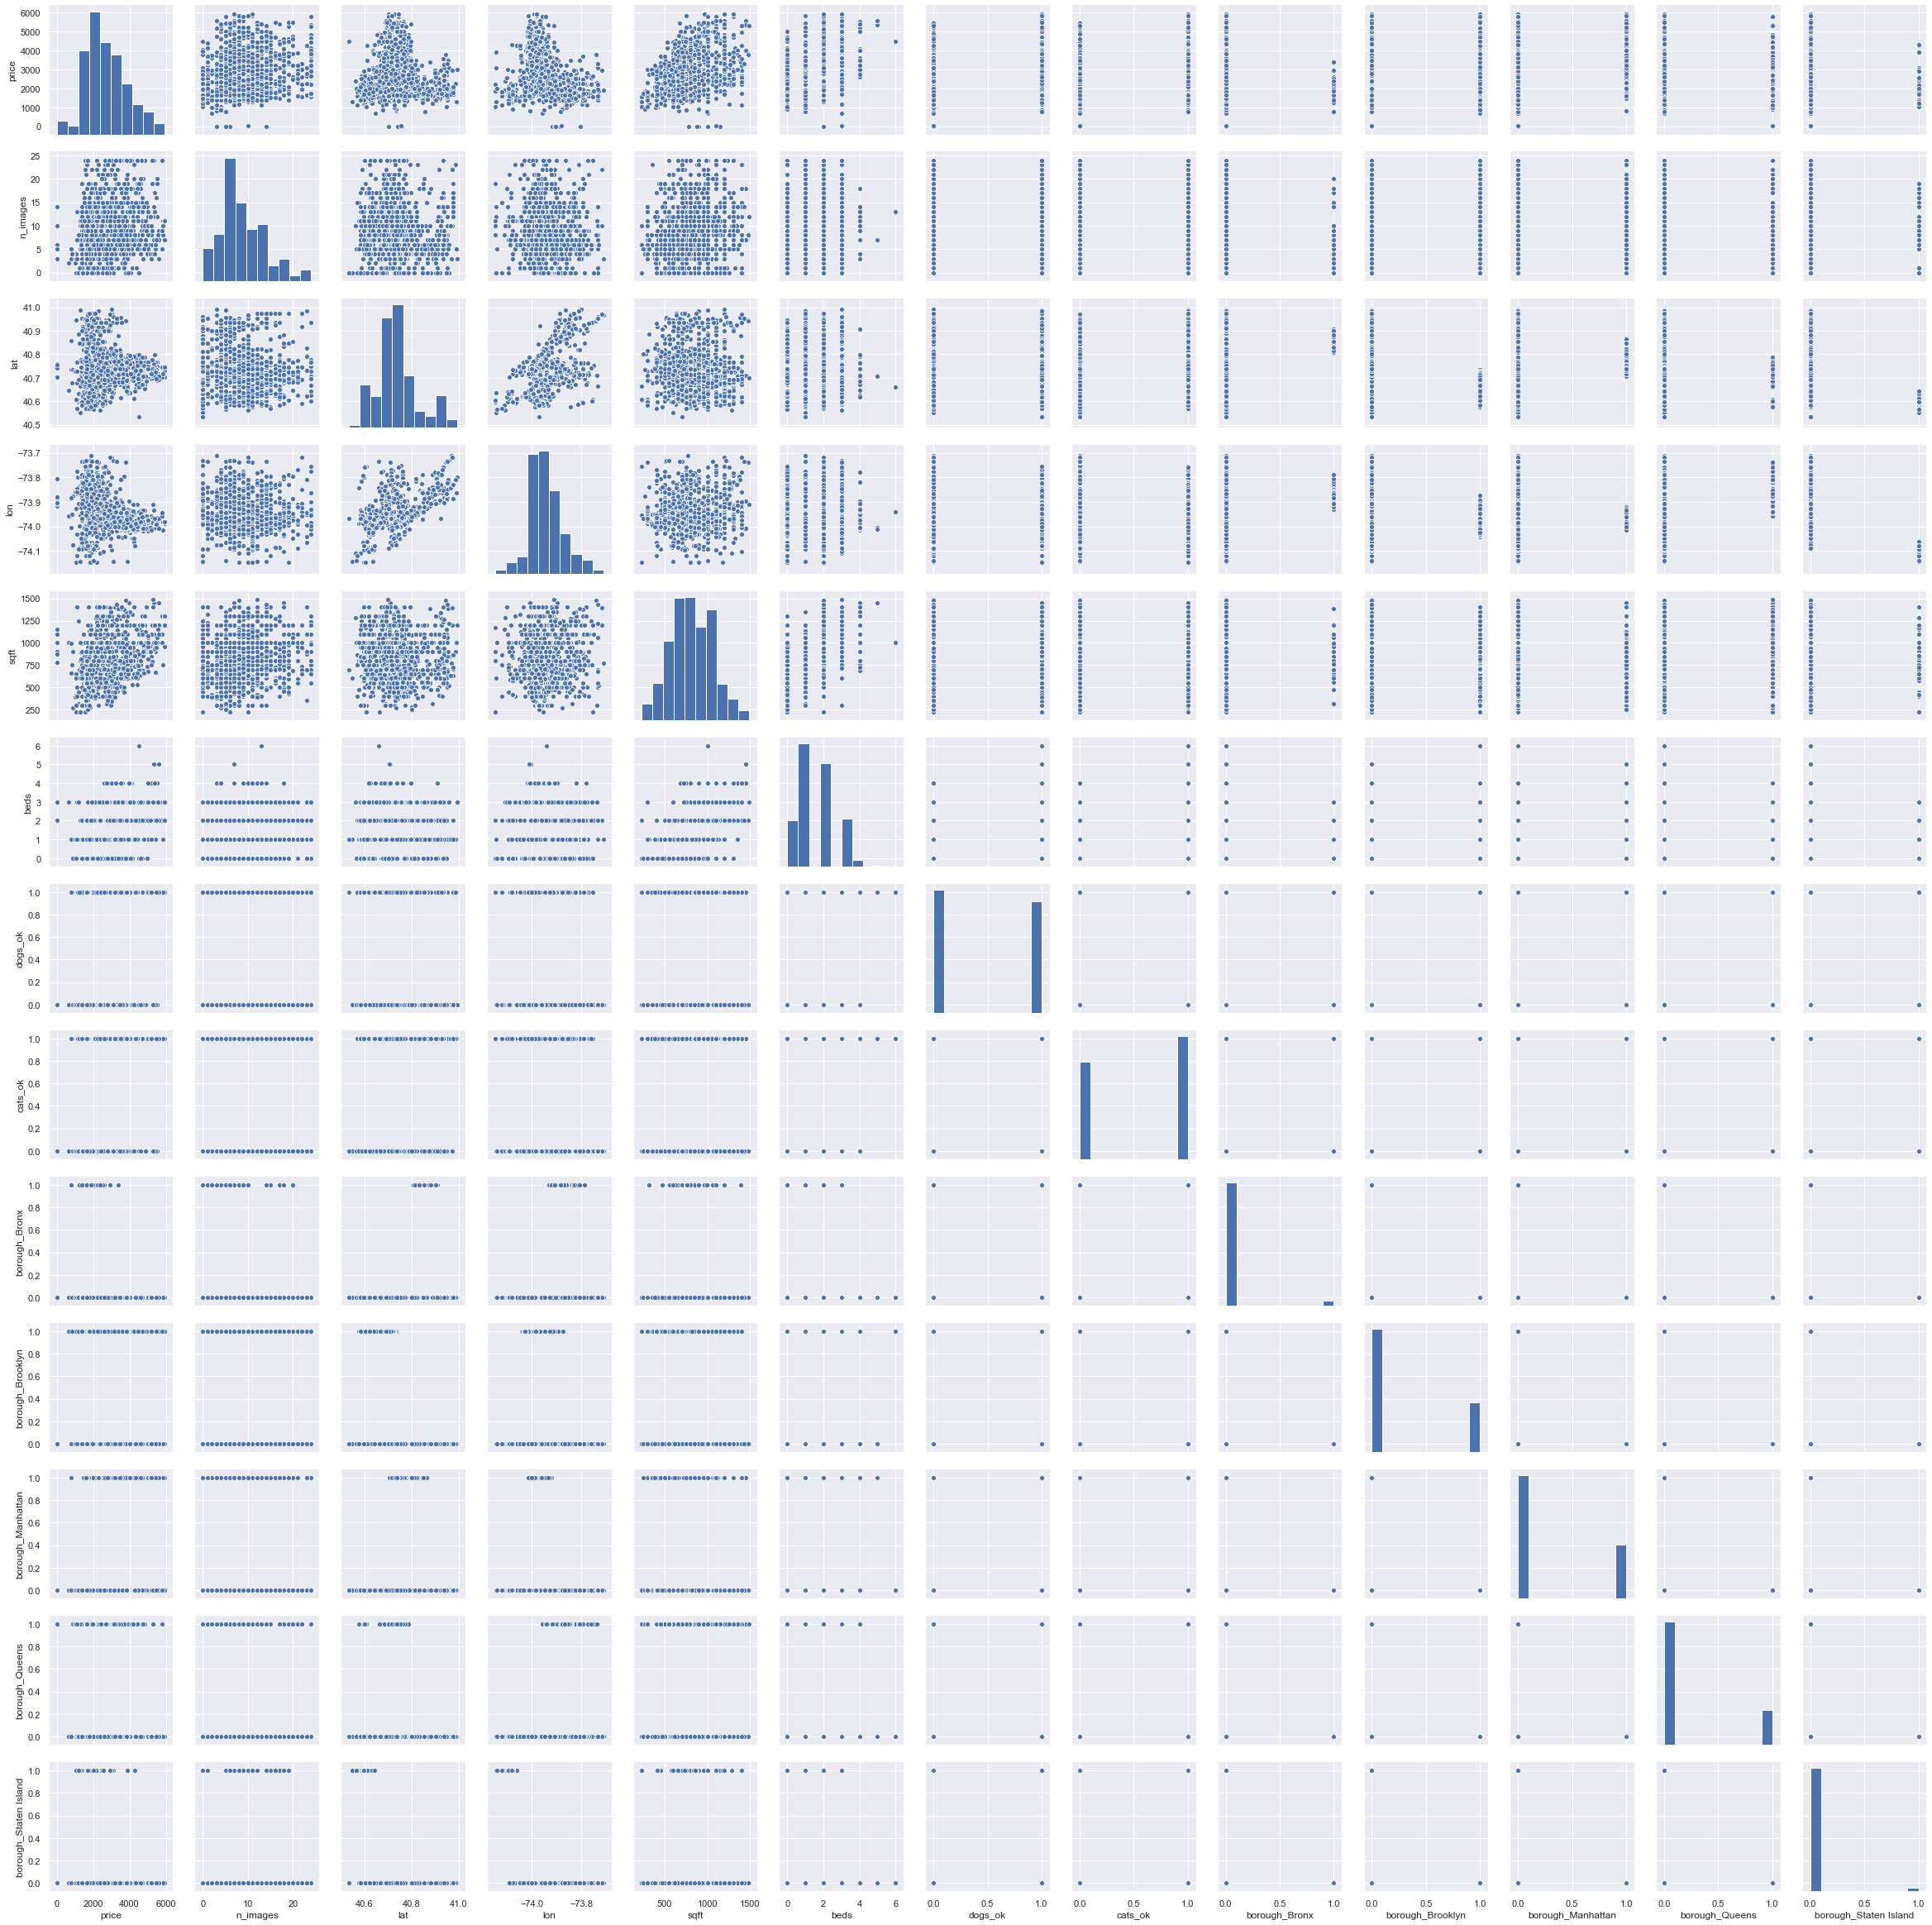

In [27]:
sns.pairplot(
    dummied_df
)

***

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Lasso, Ridge

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1902 entries, 7043852389 to 7061671040
Data columns (total 18 columns):
link            1902 non-null object
price           1902 non-null float64
description     1901 non-null object
n_images        1902 non-null int64
post_time       1902 non-null datetime64[ns]
title           1902 non-null object
placename       1902 non-null object
lat             1902 non-null float64
lon             1902 non-null float64
location        1794 non-null object
housing         1902 non-null object
attrs           1901 non-null object
sqft            1902 non-null float64
beds            1902 non-null float64
dogs_ok         1901 non-null float64
cats_ok         1901 non-null float64
neighborhood    1902 non-null object
borough         1902 non-null object
dtypes: datetime64[ns](1), float64(7), int64(1), object(9)
memory usage: 362.3+ KB


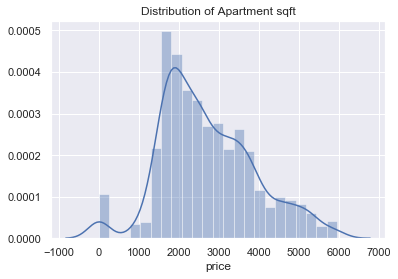

In [30]:
sns.distplot(dummied_df.price)
plt.title("Distribution of Apartment sqft")
plt.show()

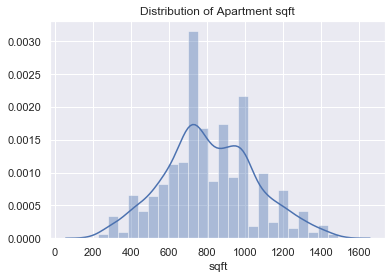

In [31]:
sns.distplot(dummied_df.sqft)
plt.title("Distribution of Apartment sqft")
plt.show()

***

I'm going to save out this dataframe just in case...

In [33]:
dummied_df.columns = [c.replace(" ","_") for c in dummied_df.columns]
dummied_df.drop(columns='neighborhood').to_sql("cl_scrape_df3",db)

***
On to the model...

In [34]:
no_na_df = dummied_df.dropna()

X = no_na_df.drop(columns=['price','neighborhood'])
y = no_na_df['price']

train_X, test_X, train_y, test_y = train_test_split(
    X,
    y,
    test_size=0.2
)
test_X, val_X, test_y, val_y = train_test_split(
    X,
    y,
    test_size=0.35
)

In [35]:
print(
    "Train X:",
    train_X.shape, 
    "  Train y:",
    train_y.shape
)
print(
    "Test X:  ",
    test_X.shape,
    "  Test y:  ",
    test_y.shape
)
print(
    "Val X:   ",
    val_X.shape,
    "  Val y:   ",
    val_y.shape
)

Train X: (1520, 12)   Train y: (1520,)
Test X:   (1235, 12)   Test y:   (1235,)
Val X:    (666, 12)   Val y:    (666,)


In [49]:
m = LinearRegression().fit(train_X,train_y)
m.score(train_X,train_y)

0.5704254607793319

In [50]:
m.score(val_X,val_y)

0.5910425705381519

Now we can try adding some polynomial features

In [ ]:
pf.get_feature_names()

In [94]:
pf = PolynomialFeatures(degree=3).fit(train_X)

m.fit(pf.transform(train_X),train_y)

print("Model score on training data: %15.6f\nModel score on testing data:  %15.6f" % (
    m.score(pf.transform(train_X),train_y),
    m.score(pf.transform(val_X),val_y)
))

Model score on training data:        0.806386
Model score on testing data:         0.817105


In [108]:
m.score(pf.transform(test_X),test_y)

0.7678597832636674

Analyzing the model's residuals to look for any trends...

In [171]:
real_y = test_y.values
pred_y = m.predict(pf.transform(test_X))

In [172]:
real_y.shape, pred_y.shape

((1235,), (1235,))

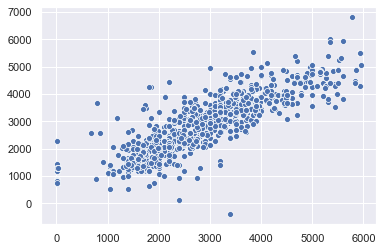

In [173]:
sns.scatterplot(
    real_y,
    pred_y
)

plt.show()

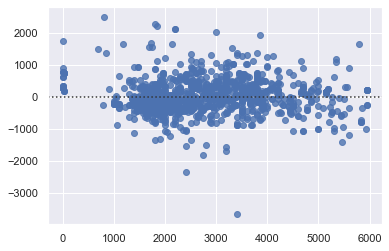

In [174]:
sns.residplot(
    real_y,
    pred_y
)

plt.show()

There don't seem to be any clear trends existing in the residuals.

***

Now, test the performance of `Ridge` and `LASSO` models on the data...

In [72]:
train_X.shape

(1520, 12)

In [71]:
alphas = [10**i for i in range(-5,5)]
scale = StandardScaler().fit(pf.transform(train_X))
lasso = RidgeCV().fit(scale.transform(pf.transform(train_X)),train_y.values)
lasso.score(scale.transform(pf.transform(train_X)),train_y.values)

0.6580730694558969

In [59]:
lasso.alpha_

10.0

In [73]:
len(lasso.coef_)

455

In [45]:
lasso.score(scale.transform(pf.transform(train_X)),train_y.values.reshape((-1,1)))

0.620446096783158

In [46]:
lasso.score(scale.transform(pf.transform(val_X)),val_y.values.reshape((-1,1)))

0.6542261305969173

***

### More Advanced Models...

Going to try out some more advanced models just to see their performance relative to previous linear models

In [76]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

Trying a `RandomForrestRegressor`

In [77]:
rfr = RandomForestRegressor(n_estimators=10).fit(train_X,train_y)
rfr.score(train_X,train_y)

0.9728015805029099

In [78]:
rfr.score(val_X, val_y)

0.9589259611001013

In [129]:
rfr

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [151]:
for i,f in sorted(list(zip(rfr.feature_importances_,train_X.columns)),reverse=True):
    print("%22s   %.3f" % (f,i))

     borough_Manhattan   0.299
                  sqft   0.224
                   lon   0.164
                   lat   0.134
              n_images   0.068
               dogs_ok   0.048
                  beds   0.036
        borough_Queens   0.012
      borough_Brooklyn   0.007
               cats_ok   0.004
 borough_Staten_Island   0.002
         borough_Bronx   0.001


Trying a `GradientBoostingRegressor`

In [79]:
gbr = GradientBoostingRegressor().fit(train_X,train_y)
gbr.score(train_X,train_y)

0.8575423718592559

In [80]:
gbr.score(val_X, val_y)

0.8700547680767305

Trying a `AdaBoostRegressor`

In [82]:
abr = AdaBoostRegressor().fit(train_X,train_y)
abr.score(train_X,train_y)

0.6388843456712664

In [83]:
abr.score(val_X, val_y)

0.6678712452416127

In [90]:
from sklearn.svm import SVR, LinearSVR

In [91]:
svm = LinearSVR().fit(train_X,train_y)
svm.score(train_X,train_y)

/Users/Austin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.3501971722749282

In [92]:
svm.score(val_X,val_y)

0.3608385506521458

Now let's try an `xgboost.XGBRegressor` model

In [105]:
from xgboost import XGBRegressor

In [106]:
xgb = XGBRegressor()
xgb.fit(train_X,train_y)
xgb.score(train_X,train_y)

[17:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/Austin/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.8481580051793004

In [107]:
xgb.score(val_X,val_y)

0.8626897101133302